Import all the files for the model grid

In [1]:
import json
import numpy as np
import pandas as pd

from sncosmo.bandpasses import _BANDPASSES
from astropy.time import Time
import glob
import matplotlib.pyplot as plt
import seaborn as sns


def loadEvent(filename):
    """
    Reads in lightcurve data from a file and returns data in a dictionary format.
    
    Args:
    - filename (str): Path to lightcurve file
    
    Returns:
    - data (dict): Dictionary containing the lightcurve data from the file. The keys are generally 't' and each of the filters in the file as well as their accompanying error values.
    """
    if filename.endswith(".json"):
        with open(filename) as f:
            data = json.load(f)
            for key in data.keys():
                data[key] = np.array(data[key])
    else:
        lines = [line.rstrip("\n") for line in open(filename)]
        lines = filter(None, lines)

        sncosmo_filts = [val["name"] for val in _BANDPASSES.get_loaders_metadata()]
        sncosmo_maps = {name: name.replace(":", "_") for name in sncosmo_filts}

        data = {}
        for line in lines:
            lineSplit = line.split(" ")
            lineSplit = list(filter(None, lineSplit))
            mjd = Time(lineSplit[0], format="isot").mjd
            filt = lineSplit[1]

            if filt in sncosmo_maps:
                filt = sncosmo_maps[filt]

            mag = float(lineSplit[2])
            dmag = float(lineSplit[3])

            if filt not in data:
                data[filt] = np.empty((0, 3), float)
            data[filt] = np.append(data[filt], np.array([[mjd, mag, dmag]]), axis=0)

    return data

def read_lightcurve_file(filename: str) -> dict:
    """
    Function to read in lightcurve file and create a dictionary containing the time (in days) at which the lightcurves 
    are evaluated and the corresponding values for different filters.
    """

    with open(filename, "r") as f:
        header = list(filter(None, f.readline().rstrip().strip("#").split(" ")))
    df = pd.read_csv(
        filename,
        delimiter=" ",
        comment="#",
        header=None,
        names=header,
        index_col=False,
    )
    df.rename(columns={"t[days]": "t"}, inplace=True)

    return df#.to_dict(orient="series")


bulla_grid_files = sorted(glob.glob("lcs_bulla_2022/*.dat"))
read_lightcurve_file(bulla_grid_files[0]).describe()

,t,bessellux,bessellb,bessellv,bessellr,besselli,sdssu,ps1::g,ps1::r,ps1::i,...,uvot::v,uvot::white,atlasc,atlaso,2massj,2massh,2massks,ztfg,ztfr,ztfi
count,100.000000,84.00000,92.00000,93.000,98.00000,99.0000,98.00000,96.00000,93.000,97.000,...,92.00000,96.000,92.00000,97.000,98.00000,100.00000,100.00000,96.00000,93.000,98.00000
mean,5.500050,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf
std,7.615685,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.103000,-16.34600,-16.18900,-16.194,-15.78000,-15.8210,-16.35900,-16.22500,-15.991,-15.907,...,-16.33300,-16.682,-16.04100,-15.667,-14.96900,-15.34400,-14.38900,-16.23000,-15.816,-15.70800
25%,0.428750,-15.35050,-14.98150,-14.864,-14.71000,-14.5825,-14.97900,-14.86025,-14.724,-14.647,...,-14.89175,-14.722,-14.85200,-14.681,-14.42075,-14.27925,-14.05275,-14.86325,-14.706,-14.60250
50%,1.784500,-12.25750,-12.87050,-13.879,-14.15500,-14.3560,-10.82650,-13.40100,-14.166,-14.344,...,-13.85200,-11.939,-13.78300,-14.238,-14.06050,-13.96200,-13.57650,-13.34950,-14.179,-14.35750
75%,7.424500,-4.01975,-4.58425,-6.996,-7.13625,-8.8445,-0.82175,-4.59300,-8.075,-8.953,...,-7.39050,-3.867,-6.93475,-8.171,-11.61725,-12.01775,-12.02000,-4.35725,-8.944,-9.01525
max,30.890000,inf,inf,inf,inf,inf,inf,inf,inf,inf,...,inf,inf,inf,inf,inf,inf,inf,inf,inf,inf


Copy interpolation strategy. Not sure what n_features is

In [3]:
from sklearn.metrics import accuracy_score
from scipy.interpolate import interp1d

def resample_series(X, num_points, new_length=100):
    """
    Resamples time series data to a fixed number of points using linear interpolation.
    
    Parameters:
        X (array): The input array containing time series data of shape (n_samples, n_timesteps, n_features).
        num_points (int): The number of time points to use from the original series for interpolation.
        new_length (int): The new number of time points desired for each series.
    
    Returns:
        numpy.array: The resampled time series data.
    """
    X_resampled = np.zeros((X.shape[0], new_length, X.shape[2]))
    for i in range(X.shape[0]):
        for j in range(X.shape[2]):
            interp_func = interp1d(np.arange(num_points), X[i, :num_points, j], kind='linear', fill_value='extrapolate')
            X_resampled[i, :, j] = interp_func(np.linspace(0, num_points - 1, new_length))
    return X_resampled

In [4]:
def fwhm(lightcurve, filter):
    '''
    Function to calculate the duration the lightcurve is brighter than the half maximum value. Here, lightcurves are in magnitudes, so the "maximum" is the most negative value. less negative values are dimmer than more negative values.
    
    Args:
    - lightcurve (string): path to lightcurve. Read in by read_lightcurve_file (NMMA Note: using pandas here, will have to later adapt to using the dict as is standard for the NMMA version of function)
    - filter (string, list): filter(s) to calculate FWHM for. If multiple filters are provided in a list, the function will return each filter's FWHM as a dictionary.
    
    Returns:
    - FWHM (float, dict): dictionary where each key corresponds to a filter and each value is a tuple containing the maximum magnitude in the first index and the duration it is brighter than half maximum in the second index.
    
    TODO: make more resilient to positive magnitudes, switch to using dict as input
    '''
    
    ## read in lightcurve
    lc = read_lightcurve_file(lightcurve)
    
    ## if filter is a string, convert to list
    if isinstance(filter, str):
        filter = [filter]
    
    ## ensure all filters are in the lightcurve 
    for f in filter:
        if f not in lc.columns:
            raise ValueError(f"Filter {f} not in lightcurve. Available filters are {lc.columns.pop('t')}")
    
    ## calculate the maximum magnitude for each filter and then calculate the duration it is brighter than half the maximum
    FWHM = {}
    for f in filter:
        max_mag = lc[f].min()
        bright = lc[lc[f] < max_mag/2]
        duration = bright["t"].max() - bright["t"].min()
        FWHM[f] = (max_mag, duration)
    return FWHM


In [5]:
fwhm(bulla_grid_files[0], "ztfg")

{'ztfg': (-16.23, 4.009)}

In [6]:


# Initialize an empty list to store the results
df_list = []
filters = ['ztfg', 'ztfr', 'ztfi']
# Loop through the files
for f in bulla_grid_files:
    # Loop through the filters
    for filt in filters:
        # Calculate the FWHM
        fwhm_value = fwhm(f, filt)
        # Create a temporary DataFrame and append it to the list
        df_temp = pd.DataFrame({'file': [f], 'filter': [filt], 'peak_magnitude': [fwhm_value[filt][0]], 'fwhm': [fwhm_value[filt][1]]})
        df_list.append(df_temp)

# Concatenate all the dataframes in the list
df_fwhm = pd.concat(df_list, ignore_index=True)

KeyboardInterrupt: 

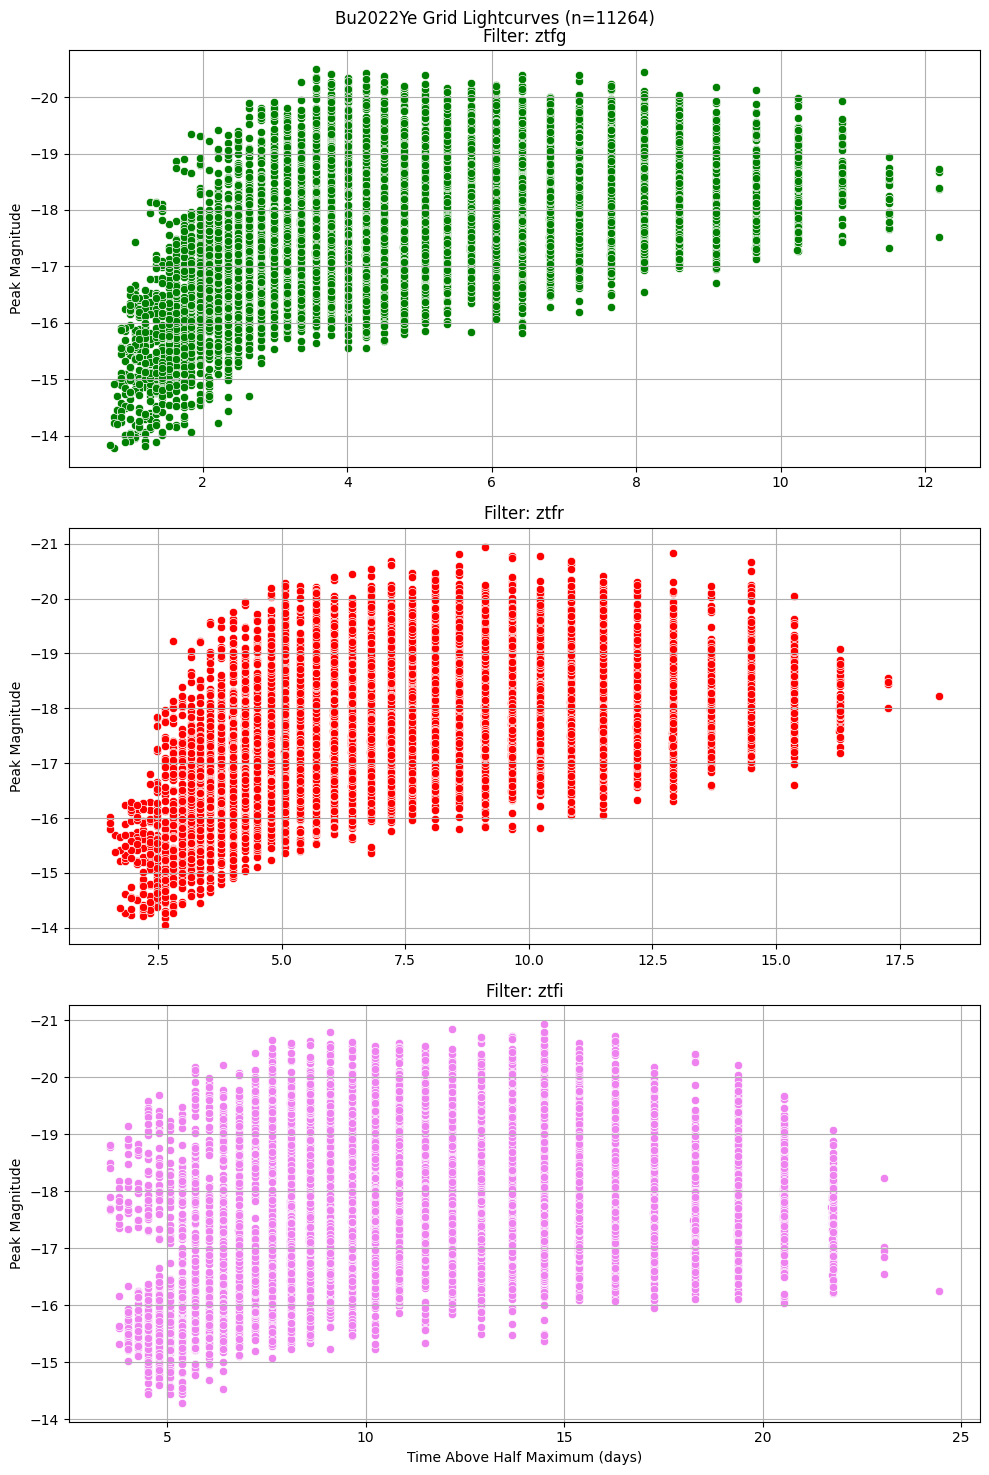

In [ ]:
# Create a 3 subplot figure
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
colors = ['green', 'red', 'violet']
# Loop through the filters and plot the data
for i, filter in enumerate(['ztfg', 'ztfr', 'ztfi']):
    axs[i].grid()
    df_filter = df_fwhm[df_fwhm['filter'] == filter]
    sns.scatterplot(data=df_filter, x='fwhm', y='peak_magnitude', ax=axs[i], color=colors[i]).set_title(f'Filter: {filter}')
    axs[i].invert_yaxis()
    axs[i].set_xlabel('Time Above Half Maximum (days)') if i == 2 else axs[i].set_xlabel('')
    axs[i].set_ylabel('Peak Magnitude')
    

plt.suptitle(f'Bu2022Ye Grid Lightcurves (n={len(bulla_grid_files)})')
plt.tight_layout()
plt.show()

Import the Imposters

In [2]:
df_ztfrest = pd.read_csv('ZTFReST.csv')
ztfredshifts = df_ztfrest.dropna(subset=["redshift"]).copy().reset_index(drop=True)
ztfredshifts.head()

,id,ra [deg],dec [deg],redshift,classification,probability,annotation origin,annotation origin key-value pair count,annotation key,annotation value,groups,Saved at,Alias,Origin,TNS
0,ZTF24aaifosg,208.285757,35.720632,0.041130,NaN,NaN,EM+GW PtAu:PtAu_gal;WIS_Test:Weizmann_Test;aca...,30;14;8;8;8;8;30;31;27;27;8;14;27;14;14;31;10;...,drb;FWHM;CLU_z;magpsf;deltajd;gal_lat;min-mag;...,0.99996;3.67;0.0412050001;20.018;0.98338;74.31...,Fritz TNS;Anomalies;Census of the Local Univer...,2024-04-04T14:55:02,NaN,Kowalski,AT 2024fkm
1,ZTF23abtycgb,54.719917,40.988617,0.020127,Type II,0.5,EM+GW PtAu:PtAu_gal;RCF Deep:RCF Deep;RCFDeepP...,30;17;17;8;8;8;30;31;13;27;8;14;27;31;16;17;18...,drb;FWHM;CLU_z;magpsf;deltajd;gal_lat;min-mag;...,1;2.26;0.0201270003;19.142;0.02073;-11.61025;1...,RCF Deep Survey;Fritz TNS;Redshift Completenes...,2023-12-15T16:51:43,NaN,Kowalski,SN 2023zzk
2,ZTF23absbqun,67.334321,70.427086,0.010150,Ib,0.3,EM+GW PtAu:PtAu_gal;RCF Deep:RCF Deep;RCFDeepP...,30;17;17;14;8;8;8;30;31;13;27;8;14;27;14;16;17...,drb;FWHM;CLU_z;magpsf;deltajd;gal_lat;min-mag;...,"0.99997;3.83;0.012128969342353857,0.0101699997...",RCF Deep Survey;Fritz TNS;Redshift Completenes...,2023-12-11T17:35:57,NaN,Kowalski,SN 2023zaw
3,ZTF23abobwsd,19.545975,38.442367,0.024303,IIb,0.95,EM+GW PtAu:PtAu_gal;RCF Deep:RCF Deep;RCFDeepP...,30;17;17;14;8;8;8;30;31;13;27;8;14;27;14;16;17...,drb;FWHM;CLU_z;magpsf;deltajd;gal_lat;min-mag;...,"1;1.78;0.0243030004,0.027229231425611067;18.04...",RCF Deep Survey;Fritz TNS;Redshift Completenes...,2023-11-01T20:23:27,NaN,Kowalski,SN 2023wdd
4,ZTF23abjwgre,359.024463,29.377942,0.022608,Type II;Type II,0.66;0.8,EM+GW PtAu:PtAu_gal;RCF Deep:RCF Deep;RCFDeepP...,30;17;17;14;8;8;8;30;31;13;27;8;14;27;14;31;16...,drb;FWHM;CLU_z;magpsf;deltajd;gal_lat;min-mag;...,"0.99997;2.52;0.022608473896980286,0.022826008,...",Same host SNe;RCF Deep Survey;Fritz TNS;Redshi...,2023-10-16T16:34:52,NaN,Kowalski,SN 2023vcg


In [3]:
objIds = list(set(ztfredshifts["id"]))
print(objIds)

['ZTF24aaifosg', 'ZTF21aapkbav', 'ZTF20acgigfo', 'ZTF23aaemgsd', 'ZTF22aailsqb', 'ZTF21aareeit', 'ZTF21aaafmhn', 'ZTF20acxooqk', 'ZTF23abtycgb', 'ZTF22abfxmpc', 'ZTF21aaeyldq', 'ZTF20acqntkr', 'ZTF21aabxjqr', 'ZTF20acutkgr', 'ZTF23abjwgre', 'ZTF22abmsaxp', 'ZTF22aahgvlx', 'ZTF22abtonmb', 'ZTF20abwysqy', 'ZTF20abstsxb', 'ZTF21aaiblte', 'ZTF22aabjpxh', 'ZTF23aaeozpp', 'ZTF23abcynsv', 'ZTF23abgsmsg', 'ZTF23abobwsd', 'ZTF21abhywxv', 'ZTF23aaxeacr', 'ZTF22aajkkwd', 'ZTF21abbvvmf', 'ZTF20acpkefi', 'ZTF22aazmooy', 'ZTF22aajrrzz', 'ZTF21abfmpwn', 'ZTF20acozryr', 'ZTF23aaoohpy', 'ZTF23aaimsja', 'ZTF22aaajecp', 'ZTF21aagwbjr', 'ZTF23absbqun', 'ZTF21aaarlbp']


In [17]:
import os
import json
import numpy as np

dataDir = "data/"
objId = "ZTF24aascytf"
objDirectory = os.path.join(dataDir, objId)

photometryFile = os.path.join(objDirectory, 'photometry.json')
with open(photometryFile) as f:
    photometry = json.load(f)

spectraFile = os.path.join(objDirectory, 'spectra.json')
with open(spectraFile) as f:
    spectra = json.load(f)

In [7]:
import os
import json

data_folder = 'data/'
photometry_dict = {}

for root, dirs, files in os.walk(data_folder):
    for file in files:
        if file == 'photometry.json':
            folder_name = os.path.basename(root)
            file_path = os.path.join(root, file)
            with open(file_path, 'r') as f:
                photometry_dict[folder_name] = json.load(f)


In [8]:
display(photometry_dict.keys())
lc_dict = {key: pd.DataFrame.from_dict(val) for key, val in photometry_dict.items()}


dict_keys(['ZTF20acpjgkt', 'ZTF20aazrcbp', 'ZTF21abvierr', 'ZTF19aapfmki', 'ZTF24aafuvmu', 'ZTF21abinaiu', 'ZTF23abobwsd', 'ZTF22aakhkoc', 'ZTF22aaigbnr', 'ZTF23abjwgre', 'ZTF22aaazmxq', 'ZTF22abpxhnj', 'ZTF21abkkcev', 'ZTF22abgtqpb', 'ZTF20aburywx', 'ZTF22aayluxo', 'ZTF21abexegc', 'ZTF23aabmzlp', 'ZTF22abijszk', 'ZTF23aajlohn', 'ZTF20acqehqq', 'ZTF20aahfqpm', 'ZTF22abbjzmp', 'ZTF24aagnnor', 'ZTF20acutkgr', 'ZTF18abffyqp', 'ZTF23aahnnrr', 'ZTF21aaafmhn', 'ZTF22abaowkz', 'ZTF23aavtwvs', 'ZTF23aajfnyc', 'ZTF23aajazzg', 'ZTF19abxjrge', 'ZTF21aavqior', 'ZTF20acpuwbf', 'ZTF22abfjnpj', 'ZTF22abntkbk', 'ZTF22abvvmti', 'ZTF20abmvjda', 'ZTF21aaabwfu', 'ZTF23aajaxvk', 'ZTF22abjibjf', 'ZTF19abacxod', 'ZTF23abcynsv', 'ZTF18aakuewf', 'ZTF23aaxeacr', 'ZTF19abobxik', 'ZTF23aaikakr', 'ZTF22abwooun', 'ZTF18abvkwlam', 'ZTF19acayojs', 'ZTF21abvczhr', 'ZTF20acxouxk', 'ZTF23absbqun', 'ZTF21aapkbav', 'ZTF21abuysnl', 'ZTF23aaoohpy', 'ZTF22aazmooy', 'ZTF23abbfrqp', 'ZTF19abxtcio', 'ZTF23abrzabc', 'ZTF24aabqdo

In [9]:
# Initialize an empty dictionary to store non-empty items
flc_dict = {}
elc_dict = {}

# Iterate over the items in lc_dict
for key, value in lc_dict.items():
    # Check if the value is not empty
    if not value.empty:
        # If the value is not empty, add it to the new dictionary
        flc_dict[key] = value
    else:
        # If the value is empty, print the key
        print(f"{key}")
        elc_dict[key] = value

# Now non_empty_lc_dict contains only the items from lc_dict that are not empty

print('number of non-empty lightcurves:', len(flc_dict))
print('number of empty lightcurves:', len(elc_dict))

ZTF20aazrcbp
ZTF22abvvmti
ZTF19abobxik
ZTF18abvkwlam
ZTF19acayojs
ZTF20abmocba
194.94985-47.75
ZTF19aankdan
ZTF18abfcmjwm
ZTF20acigmelm
ZTF20aaelulum
ZTF20ababxjv
ZTF19abuvqgw
ZTF19abrpfps
Swift-J002325.5-141701
ZTF18abukavnm
ZTF19accxzsc
ZTF18abianhw
ZTF19aasexmy
ZTF19aapuudk
ZTF19abeyvoi
Swift-J181727.0-192921
ZTF19acaxbjt
number of non-empty lightcurves: 191
number of empty lightcurves: 23


In [11]:

display(flc_dict[list(flc_dict.keys())[-1]].head())
display(flc_dict[list(flc_dict.keys())[2]].head())
# display(flc_dict[list(flc_dict.keys())[0]][flc_dict[list(flc_dict.keys())[0]]['filter'] == 'ztfg'])
# display(flc_dict[list(flc_dict.keys())[1]][flc_dict[list(flc_dict.keys())[1]]['filter'] == 'ztfg'])

,obj_id,ra,dec,filter,mjd,snr,instrument_id,instrument_name,ra_unc,dec_unc,origin,id,altdata,created_at,groups,annotations,mag,magerr,magsys,limiting_mag
0,ZTF23abhyqqs,NaN,NaN,ztfg,60194.448368,NaN,1,ZTF,None,None,None,501161761,None,2023-10-04T12:56:58.509413,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],NaN,NaN,ab,20.213900
1,ZTF23abhyqqs,NaN,NaN,ztfr,60194.493484,NaN,1,ZTF,None,None,None,501161762,None,2023-10-04T12:56:58.509473,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],NaN,NaN,ab,20.383801
2,ZTF23abhyqqs,NaN,NaN,ztfg,60198.381053,NaN,1,ZTF,None,None,None,501161763,None,2023-10-04T12:56:58.509495,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],NaN,NaN,ab,20.415199
3,ZTF23abhyqqs,NaN,NaN,ztfr,60198.425776,NaN,1,ZTF,None,None,None,501161764,None,2023-10-04T12:56:58.509510,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],NaN,NaN,ab,20.556999
4,ZTF23abhyqqs,NaN,NaN,ztfr,60201.441736,NaN,1,ZTF,None,None,None,501161765,None,2023-10-04T12:56:58.509524,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],NaN,NaN,ab,20.688400


,obj_id,ra,dec,filter,mjd,snr,instrument_id,instrument_name,ra_unc,dec_unc,origin,id,altdata,created_at,groups,annotations,mag,magerr,magsys,limiting_mag
0,ZTF19aapfmki,211.43149,9.51574,atlasc,58486.670896,NaN,72,ATLAS,None,None,None,212371289,None,2022-05-05T08:35:35.880063,"[{'id': 1, 'created_at': '2020-10-21T01:38:02....",[],NaN,NaN,ab,18.87
1,ZTF19aapfmki,211.43149,9.51574,atlasc,58486.679946,NaN,72,ATLAS,None,None,None,212371290,None,2022-05-05T08:35:35.880150,"[{'id': 1, 'created_at': '2020-10-21T01:38:02....",[],NaN,NaN,ab,16.77
2,ZTF19aapfmki,211.43149,9.51574,atlasc,58491.669261,NaN,72,ATLAS,None,None,None,212371291,None,2022-05-05T08:35:35.880175,"[{'id': 1, 'created_at': '2020-10-21T01:38:02....",[],NaN,NaN,ab,19.24
3,ZTF19aapfmki,211.43149,9.51574,atlasc,58491.680686,NaN,72,ATLAS,None,None,None,212371292,None,2022-05-05T08:35:35.880194,"[{'id': 1, 'created_at': '2020-10-21T01:38:02....",[],NaN,NaN,ab,16.91
4,ZTF19aapfmki,211.43149,9.51574,atlasc,58494.634754,NaN,72,ATLAS,None,None,None,212371293,None,2022-05-05T08:35:35.880214,"[{'id': 1, 'created_at': '2020-10-21T01:38:02....",[],NaN,NaN,ab,19.64


In [12]:
## count the number of objects that have more than 5 observations in the ztfg filter, and then also count the number of objects that have more than 5 observations in the ztfr filter. An observation exists if the value in the 'mag' column is not NaN.
print('number of objects in flc_dict:', len(flc_dict))
count_ztfg = 0
count_ztfr = 0
for key, value in flc_dict.items():
    if value[value['filter'] == 'ztfg']['mag'].notnull().sum() > 5:
        count_ztfg += 1
    if value[value['filter'] == 'ztfr']['mag'].notnull().sum() > 5:
        count_ztfr += 1

print(f"Number of objects with more than 4 observations in ztfg: {count_ztfg}")
print(f"Number of objects with more than 4 observations in ztfr: {count_ztfr}")

number of objects in flc_dict: 191
Number of objects with more than 4 observations in ztfg: 115
Number of objects with more than 4 observations in ztfr: 126


In [13]:
## get just those objects with more than 5 observations in the ztfg filter and then separately for the ztfr filter
flc_dict_ztfg = {key: value[value['filter'] == 'ztfg'] for key, value in flc_dict.items() if value[value['filter'] == 'ztfg']['mag'].notnull().sum() > 5}
flc_dict_ztfr = {key: value[value['filter'] == 'ztfr'] for key, value  in flc_dict.items() if value[value['filter'] == 'ztfr']['mag'].notnull().sum() > 5}
## print average length of lightcurves
print('average length of ztfg lightcurves:', np.mean([len(value) for value in flc_dict_ztfg.values()]))
## only include values where the 'mag' column is not NaN
flc_dict_ztfg = {key: value[value['mag'].notnull()] for key, value in flc_dict_ztfg.items()}
flc_dict_ztfr = {key: value[value['mag'].notnull()] for key, value in flc_dict_ztfr.items()}
## print average length of lightcurves
print('average length of ztfg lightcurves:', np.mean([len(value) for value in flc_dict_ztfg.values()]))
print('number of objects in flc_dict_ztfg:', len(flc_dict_ztfg))
print('number of objects in flc_dict_ztfr:', len(flc_dict_ztfr))

average length of ztfg lightcurves: 110.94782608695652
average length of ztfg lightcurves: 40.6
number of objects in flc_dict_ztfg: 115
number of objects in flc_dict_ztfr: 126


In [14]:
## print all objects in flc_dict_ztfg/ztfr without repeating any objects. print them line by line.
combined_object_list = set(list(flc_dict.keys())) #list(flc_dict_ztfg.keys()) + list(flc_dict_ztfr.keys())
## drop duplicates
combined_object_list = sorted(list(set(combined_object_list)))
## print
for obj in combined_object_list:
    print(obj)

ZTF18aakuewf
ZTF18aalrxas
ZTF18abantmh
ZTF18abffyqp
ZTF18abvkmgw
ZTF18abwkrbl
ZTF19aanbpus
ZTF19aaojovs
ZTF19aapfmki
ZTF19aatesgp
ZTF19aatoboa
ZTF19abacxod
ZTF19abfarpa
ZTF19abxjrge
ZTF19abxtcio
ZTF19abyjzvd
ZTF19acbumks
ZTF19accjfgv
ZTF19acsakuv
ZTF20aahfqpm
ZTF20aaivtof
ZTF20aajnksq
ZTF20aakqxsq
ZTF20aakypiu
ZTF20aamsouh
ZTF20aaxhzhc
ZTF20aayrobw
ZTF20aazchcq
ZTF20abmvjda
ZTF20abstsxb
ZTF20abtxwfx
ZTF20abummyz
ZTF20aburywx
ZTF20abwysqy
ZTF20abwzqzo
ZTF20abxrugr
ZTF20acgigfo
ZTF20acgiglu
ZTF20achedzl
ZTF20acigusw
ZTF20aclfmwn
ZTF20acozryr
ZTF20acpjgkt
ZTF20acpkefi
ZTF20acpuwbf
ZTF20acqehqq
ZTF20acqirkw
ZTF20acqntkr
ZTF20actbebh
ZTF20actoqra
ZTF20actqnhg
ZTF20acutkgr
ZTF20acwbcsj
ZTF20acxooqk
ZTF20acxouxk
ZTF20acylyct
ZTF21aaabrpu
ZTF21aaabwfu
ZTF21aaafmhn
ZTF21aaarlbp
ZTF21aabtdut
ZTF21aabxjqr
ZTF21aacngji
ZTF21aacwrno
ZTF21aacxlgf
ZTF21aaczajl
ZTF21aaeyldq
ZTF21aagmecm
ZTF21aagwbjr
ZTF21aahifke
ZTF21aahjuct
ZTF21aaiblte
ZTF21aaidofu
ZTF21aaivnap
ZTF21aajzfoq
ZTF21aapkbav
ZTF21aaquyjp

In [15]:
## calculate average snr for each object in ztfg, ztfr, and ztf i and print it along with the name of the object
snr_df = pd.DataFrame(columns=['object', 'ztfg_mean', 'ztfg_min', 'ztfg_max', 'ztfr_mean', 'ztfr_min', 'ztfr_max', 'ztfi_mean', 'ztfi_min', 'ztfi_max'])
for obj in combined_object_list:
    snr_ztfg = np.mean(flc_dict[obj][flc_dict[obj]['filter'] == 'ztfg']['snr'])
    snr_ztfr = np.mean(flc_dict[obj][flc_dict[obj]['filter'] == 'ztfr']['snr'])
    snr_ztfi = np.mean(flc_dict[obj][flc_dict[obj]['filter'] == 'ztfi']['snr'])
    lowest_snr_ztfg = np.min(flc_dict[obj][flc_dict[obj]['filter'] == 'ztfg']['snr'])
    lowest_snr_ztfr = np.min(flc_dict[obj][flc_dict[obj]['filter'] == 'ztfr']['snr'])
    lowest_snr_ztfi = np.min(flc_dict[obj][flc_dict[obj]['filter'] == 'ztfi']['snr'])
    highest_snr_ztfg = np.max(flc_dict[obj][flc_dict[obj]['filter'] == 'ztfg']['snr'])
    highest_snr_ztfr = np.max(flc_dict[obj][flc_dict[obj]['filter'] == 'ztfr']['snr'])
    highest_snr_ztfi = np.max(flc_dict[obj][flc_dict[obj]['filter'] == 'ztfi']['snr'])
    snr_df = pd.concat((snr_df, pd.DataFrame({'object': [obj], 'ztfg_mean': [snr_ztfg], 'ztfg_min': [lowest_snr_ztfg], 'ztfg_max': [highest_snr_ztfg], 'ztfr_mean': [snr_ztfr], 'ztfr_min': [lowest_snr_ztfr], 'ztfr_max': [highest_snr_ztfr], 'ztfi_mean': [snr_ztfi], 'ztfi_min': [lowest_snr_ztfi], 'ztfi_max': [highest_snr_ztfi]})),ignore_index=True)
    #print(f"{obj} ztfg: {snr_ztfg} ({lowest_snr_ztfg}), ztfr: {snr_ztfr} ({lowest_snr_ztfr}), ztfi: {snr_ztfi} ({lowest_snr_ztfi})")
display(snr_df)
#snr_df.to_csv('snr_stats.csv', index=False)

,object,ztfg_mean,ztfg_min,ztfg_max,ztfr_mean,ztfr_min,ztfr_max,ztfi_mean,ztfi_min,ztfi_max
0,ZTF18aakuewf,3.767315,-11.326773,83.911913,34.212660,8.485563,69.912181,NaN,NaN,NaN
1,ZTF18aalrxas,17.011229,6.405485,38.399159,11.487167,3.800506,26.415654,NaN,NaN,NaN
2,ZTF18abantmh,15.254603,5.410691,45.032608,16.271180,5.840428,31.470615,9.300135,7.877943,10.476265
3,ZTF18abffyqp,8.369012,2.329261,22.953768,8.948563,2.600746,22.295752,5.213742,-5.396691,8.301370
4,ZTF18abvkmgw,7.458102,-5.071133,14.125603,11.932418,5.778481,15.141286,-2.577409,-7.176903,6.615139
...,...,...,...,...,...,...,...,...,...,...
186,ZTF24aafuvmu,19.951016,3.668685,201.681969,6.933015,3.430499,11.861656,32.930468,3.628478,97.986487
187,ZTF24aagnnor,2.929822,2.929822,2.929822,5.294045,5.294045,5.294045,NaN,NaN,NaN
188,ZTF24aahkzvn,NaN,NaN,NaN,53.695646,3.065708,196.359542,NaN,NaN,NaN
189,ZTF24aaifosg,9.499186,3.468429,19.446445,8.969943,7.638304,10.505613,6.276219,6.276219,6.276219


In [16]:
## print the classification of each object in df_ztfrest 
for obj in combined_object_list:
    
    continue
    
    obj_in_ztfrest = df_ztfrest[df_ztfrest['id'] == obj]
    if obj_in_ztfrest.empty or pd.isnull(obj_in_ztfrest['classification'].values[0]):
        print(f"")
    else:
        classification = df_ztfrest[df_ztfrest['id'] == obj]['classification'].values[0]
        print(f"{classification}")

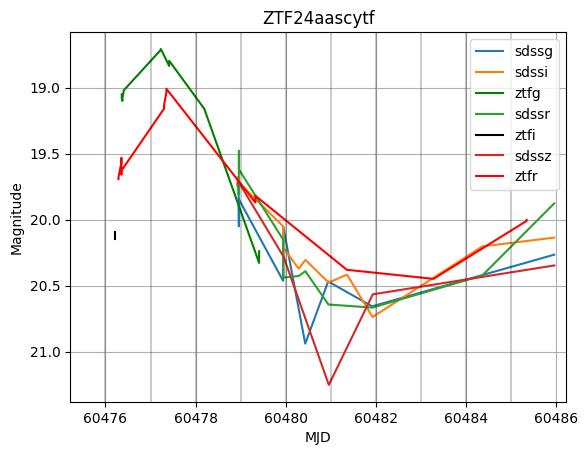

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
## plot each lightcurve in flc_dict that has a key in combined_object_list. The x-axis should be the 'mjd' column and the y-axis should be the 'mag' column. The color of the line should be determined by the 'filter' column. The title of the plot should be the key of the lightcurve.
## each plot should be a separate plot
for obj in combined_object_list:
    if obj in flc_dict:
        if obj != 'ZTF24aascytf':
            continue
        temp_df = flc_dict[obj]
        temp_df = temp_df[temp_df['snr'] > 0]
        for filt in set(['ztfg','ztfr','ztfi'] + temp_df['filter'].unique().tolist()):
            if filt in ['ztfg', 'ztfr', 'ztfi']:
                color = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'black'}[filt]
                plt.plot(temp_df[(temp_df['filter'] == filt) & (temp_df['mag'].notnull())]['mjd'], temp_df[(temp_df['filter'] == filt) & (temp_df['mag'].notnull())]['mag'], label=filt, color=color)
            else:
                plt.plot(temp_df[(temp_df['filter'] == filt) & (temp_df['mag'].notnull())]['mjd'], temp_df[(temp_df['filter'] == filt) & (temp_df['mag'].notnull())]['mag'], label=filt)
        plt.gca().invert_yaxis()
        plt.grid()
        plt.title(obj)
        plt.xlabel('MJD')
        plt.ylabel('Magnitude')
        if temp_df['mag'].notnull().sum() == 0:
            plt.show()
            continue
        earliest_observation = temp_df[temp_df['mag'].notnull()]['mjd'].min() 
        latest_observation = temp_df[temp_df['mag'].notnull()]['mjd'].max()
        ## set max x limit to the max mjd value for a detection
        plt.xlim(earliest_observation-1, earliest_observation+10)
        [plt.axvline(x=value, color='black',alpha=0.2) for value in range(60476,60486)];
        plt.legend()
        plt.show()

In [59]:
## set the first time of observation to be t=0 for each object and adjust the other times accordingly. The t=0 value should be specific to each object.
flc_dict_ztfg = {key: value.assign(t = value['mjd'] - value['mjd'].min()) for key, value in flc_dict_ztfg.items()}
flc_dict_ztfr = {key: value.assign(t = value['mjd'] - value['mjd'].min()) for key, value in flc_dict_ztfr.items()}
        
display(flc_dict_ztfg[list(flc_dict_ztfg.keys())[0]]['mag'].notnull())

41    True
42    True
48    True
51    True
56    True
57    True
58    True
61    True
65    True
Name: mag, dtype: bool

In [60]:
flc_dict_ztfr

{'ZTF20acpjgkt':           obj_id          ra        dec filter           mjd       snr  \
 63  ZTF20acpjgkt  319.063398  15.964374   ztfr  59164.131354  6.904347   
 67  ZTF20acpjgkt  319.063388  15.964299   ztfr  60374.549120  8.037322   
 68  ZTF20acpjgkt  319.063388  15.964299   ztfr  60374.549120  8.037311   
 69  ZTF20acpjgkt  319.063333  15.964375   ztfr  60374.549595  7.813129   
 70  ZTF20acpjgkt  319.063333  15.964375   ztfr  60374.549595  7.813132   
 71  ZTF20acpjgkt  319.063449  15.964387   ztfr  60374.550058  7.978576   
 
     instrument_id instrument_name ra_unc dec_unc  ...         id  altdata  \
 63              1             ZTF   None    None  ...    2083620     None   
 67              1             ZTF   None    None  ...  543380612     None   
 68              1             ZTF   None    None  ...  543381134     None   
 69              1             ZTF   None    None  ...  543381135     None   
 70              1             ZTF   None    None  ...  543381596  

In [61]:
## print the  number of objects that have more than 10 observations in the ztfg filter and then also count the number of objects that have more than 10 observations in the ztfr filter. An observation exists if the value in the 'mag' column is not NaN.
print('number of objects in flc_dict:', len(flc_dict))
count_ztfg = 0
count_ztfr = 0
for key, value in flc_dict.items():
    if value[value['filter'] == 'ztfg']['mag'].notnull().sum() > 10:
        count_ztfg += 1
    if value[value['filter'] == 'ztfr']['mag'].notnull().sum() > 10:
        count_ztfr += 1

print(f"Number of objects with more than 10 observations in ztfg: {count_ztfg}")
print(f"Number of objects with more than 10 observations in ztfr: {count_ztfr}")

number of objects in flc_dict: 190
Number of objects with more than 10 observations in ztfg: 78
Number of objects with more than 10 observations in ztfr: 93


In [62]:
flc_dict_ztfr[[*flc_dict_ztfr][0]]

,obj_id,ra,dec,filter,mjd,snr,instrument_id,instrument_name,ra_unc,dec_unc,...,id,altdata,created_at,groups,annotations,mag,magerr,magsys,limiting_mag,t
63,ZTF20acpjgkt,319.063398,15.964374,ztfr,59164.131354,6.904347,1,ZTF,None,None,...,2083620,None,2020-11-11T07:57:10.661560,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],19.770100,0.157254,ab,20.264400,0.000000
67,ZTF20acpjgkt,319.063388,15.964299,ztfr,60374.549120,8.037322,1,ZTF,None,None,...,543380612,None,2024-03-05T14:13:49.936403,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],18.792772,0.135087,ab,19.308126,1210.417766
68,ZTF20acpjgkt,319.063388,15.964299,ztfr,60374.549120,8.037311,1,ZTF,None,None,...,543381134,None,2024-03-05T14:15:22.500951,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],18.792801,0.135087,ab,19.308153,1210.417766
69,ZTF20acpjgkt,319.063333,15.964375,ztfr,60374.549595,7.813129,1,ZTF,None,None,...,543381135,None,2024-03-05T14:15:22.501054,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],18.615136,0.138963,ab,19.099773,1210.418241
70,ZTF20acpjgkt,319.063333,15.964375,ztfr,60374.549595,7.813132,1,ZTF,None,None,...,543381596,None,2024-03-05T14:16:09.968547,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],18.615101,0.138963,ab,19.099739,1210.418241
71,ZTF20acpjgkt,319.063449,15.964387,ztfr,60374.550058,7.978576,1,ZTF,None,None,...,543381597,None,2024-03-05T14:16:09.968607,"[{'id': 3, 'created_at': '2020-10-21T06:20:33....",[],18.607935,0.136081,ab,19.115324,1210.418704


In [63]:
## get only the lightcurves with more than 10 observations, define dictionaries for each filter prepended by 'hq_' for high quality
hq_flc_dict_ztfg = {key: value[value['filter'] == 'ztfg'] for key, value in flc_dict_ztfg.items() if value[value['filter'] == 'ztfg']['mag'].notnull().sum() > 10}
hq_flc_dict_ztfr = {key: value[value['filter'] == 'ztfr'] for key, value in flc_dict_ztfr.items() if value[value['filter'] == 'ztfr']['mag'].notnull().sum() > 10}
## print average length of lightcurves
print('average length of ztfg lightcurves:', np.mean([len(value) for value in hq_flc_dict_ztfg.values()]))


average length of ztfg lightcurves: 55.92307692307692


In [64]:
## temporarily concat all the lightcurves into a single dataframe to find the max and min t values
flc_ztfg_temp = pd.concat(hq_flc_dict_ztfg.values())
flc_ztfg_temp.describe()

,ra,dec,mjd,snr,instrument_id,id,mag,magerr,limiting_mag,t
count,4322.000000,4322.000000,4362.000000,4362.000000,4362.0,4.362000e+03,4362.000000,4362.000000,4362.000000,4362.000000
mean,210.038392,26.546853,59469.057246,11.220114,1.0,2.733847e+08,19.151055,0.143821,20.030875,238.526014
std,95.208696,19.338412,627.390652,10.307406,0.0,1.820336e+08,1.245683,0.074958,0.756207,461.361313
min,9.361888,-27.949081,58227.333113,2.329261,1.0,3.580550e+05,12.617463,0.005383,15.212784,0.000000
25%,150.966119,15.376569,59080.434123,5.967618,1.0,1.539869e+08,18.823481,0.089022,19.707175,6.960243
50%,243.594361,33.034953,59517.492905,7.806549,1.0,2.011138e+08,19.558524,0.139080,20.163800,25.984919
75%,258.559801,35.917966,60054.419907,12.196250,1.0,4.550495e+08,19.775299,0.181938,20.578300,136.638770
max,359.444438,72.283093,60408.351250,201.681969,1.0,5.504386e+08,21.412485,0.466129,21.953699,2141.009618


In [65]:
## print name of objects with more than 1000 days of observations
for key, value in flc_dict_ztfg.items():
    if value['t'].max() > 1000:
        print(key)

ZTF18aakuewf
ZTF21aacwrno
ZTF18abantmh
ZTF20acwbcsj
ZTF23abhxvun


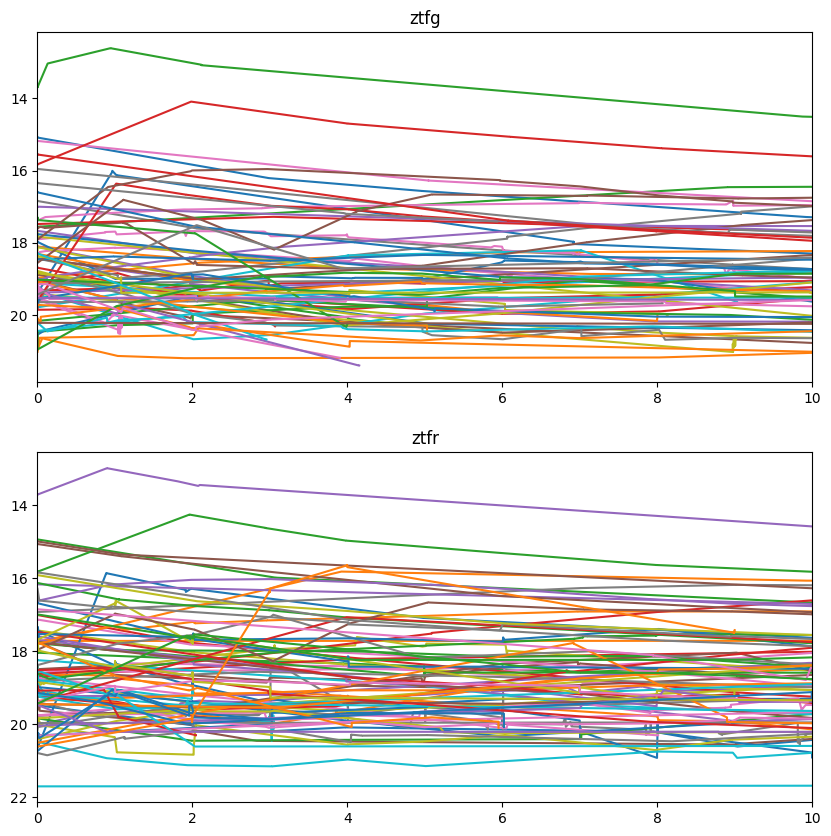

In [72]:
## plot each of the lightcurves in flc_dict_ztfg and flc_dict_ztfr in 2 separate plots
fig, axs = plt.subplots(2, 1, figsize=(10, 10))
for key, value in hq_flc_dict_ztfg.items():
    axs[0].plot(value['t'], value['mag'], label=key)
axs[0].set_title('ztfg')
axs[0].invert_yaxis()
for key, value in hq_flc_dict_ztfr.items():
    axs[1].plot(value['t'], value['mag'], label=key)
axs[1].set_title('ztfr')
axs[1].invert_yaxis()
axs[0].set_xlim(0, 10), axs[1].set_xlim(0, 10)
plt.show()

In [67]:
## calculate the full width at half max for each lightcurve in hq_flc_dict_ztfg and hq_flc_dict_ztfr
def calc_df_fwhm(df):
    """
    Function to calculate the duration the lightcurve is brighter than the half maximum value. Here, lightcurves are in magnitudes, so the "maximum" is the most negative value. less negative values are dimmer than more negative values.
    
    Args:
    - df (pd.DataFrame): lightcurve data. 
    
    Returns:
    - FWHM (float): duration the lightcurve is brighter than half maximum.
    """
    max_mag = df['mag'].min()
    # print(max_mag)
    bright = df[df['mag'] > max_mag/2]
    # print(bright)
    ## is this maybe an issue if there are random spikes?
    duration = bright['t'].max() - bright['t'].min()
    return (max_mag, duration)

ztf_fwhm_ztfg = {key: calc_df_fwhm(value) for key, value in hq_flc_dict_ztfg.items()}
ztf_fwhm_ztfr = {key: calc_df_fwhm(value) for key, value in hq_flc_dict_ztfr.items()}
print(hq_flc_dict_ztfr)
print(ztf_fwhm_ztfr)

{'ZTF21abvierr':           obj_id          ra       dec filter           mjd       snr  \
39  ZTF21abvierr  346.448512  5.884123   ztfr  59451.314572  4.608095   
45  ZTF21abvierr  346.448355  5.884074   ztfr  59453.324201  6.244708   
46  ZTF21abvierr  346.448397  5.884093   ztfr  59453.325151  5.333437   
47  ZTF21abvierr  346.448397  5.884093   ztfr  59453.325151  5.333426   
50  ZTF21abvierr  346.448372  5.884093   ztfr  59454.315336  4.907260   
53  ZTF21abvierr  346.448399  5.884108   ztfr  59455.291354  5.565406   
54  ZTF21abvierr  346.448399  5.884108   ztfr  59455.291354  5.565395   
59  ZTF21abvierr  346.448465  5.884131   ztfr  59459.270868  5.360331   
60  ZTF21abvierr  346.448465  5.884131   ztfr  59459.270868  5.360337   
64  ZTF21abvierr  346.448456  5.884113   ztfr  59460.347211  6.005333   
66  ZTF21abvierr  346.448402  5.884088   ztfr  59461.299352  5.434919   

    instrument_id instrument_name ra_unc dec_unc  ...         id  altdata  \
39              1            

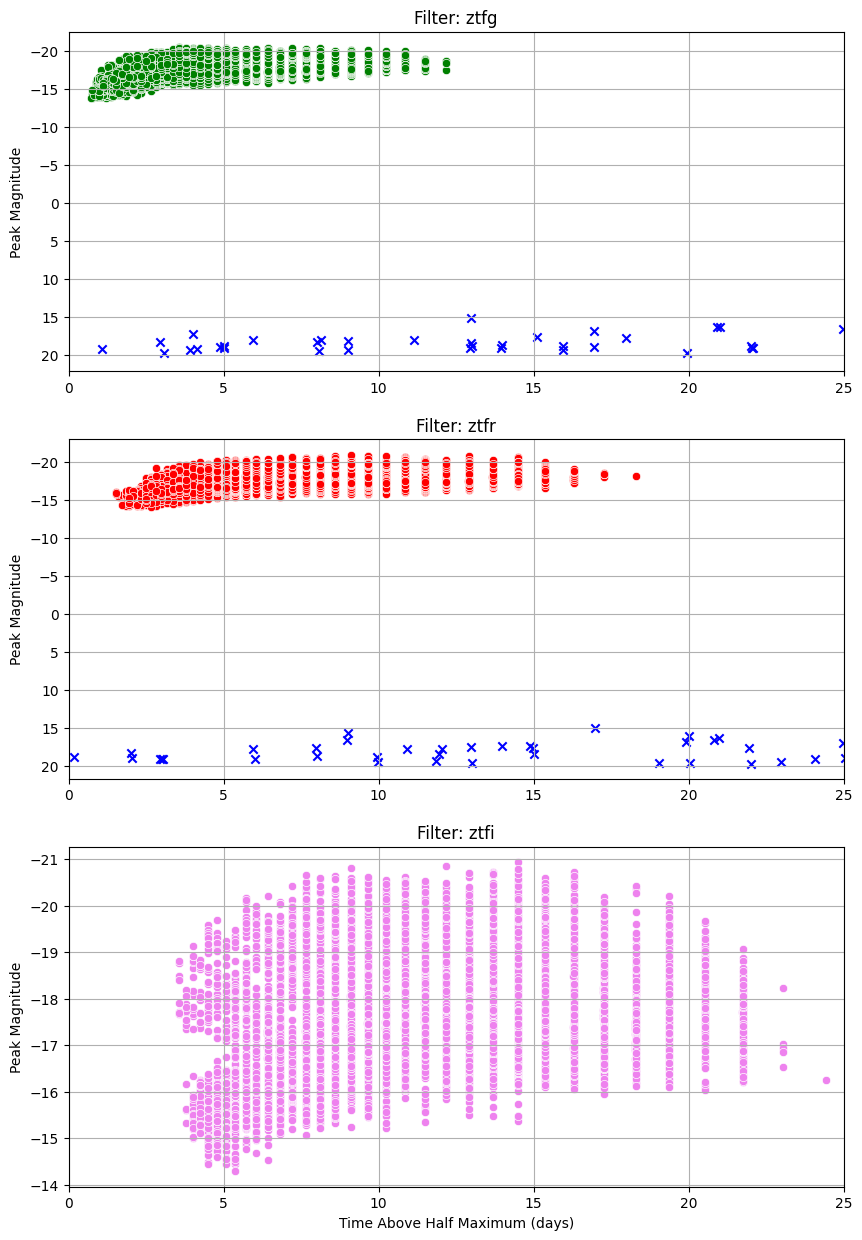

In [69]:
df_fwhm = pd.concat(df_list, ignore_index=True)
fig, axs = plt.subplots(3, 1, figsize=(10, 15))
colors = ['green', 'red', 'violet']
# Loop through the filters and plot the data
for i, filter in enumerate(['ztfg', 'ztfr', 'ztfi']):
    axs[i].grid()
    df_filter = df_fwhm[df_fwhm['filter'] == filter]
    sns.scatterplot(data=df_filter, x='fwhm', y='peak_magnitude', ax=axs[i], color=colors[i]).set_title(f'Filter: {filter}')
    axs[i].invert_yaxis()
    axs[i].set_xlabel('Time Above Half Maximum (days)') if i == 2 else axs[i].set_xlabel('')
    axs[i].set_ylabel('Peak Magnitude')
    

# plt.suptitle(f'Bu2022Ye Grid Lightcurves (n={len(bulla_grid_files)})')
# plt.tight_layout()
# plt.show()

for key, value in ztf_fwhm_ztfg.items():
    axs[0].scatter(value[1], value[0], marker='x', color='blue')
    
for key, value in ztf_fwhm_ztfr.items():
    axs[1].scatter(value[1], value[0], marker='x', color='blue')
    
axs[0].set_xlim(0, 25), axs[1].set_xlim(0, 25), axs[2].set_xlim(0, 25)

plt.show()

In [25]:
# ## max value in ztfg for each object
# max_ztfg = {key: val[val['filter'] == 'ztfg']['mag'].max() for key, val in flc_dict.items()}
# max_ztfg

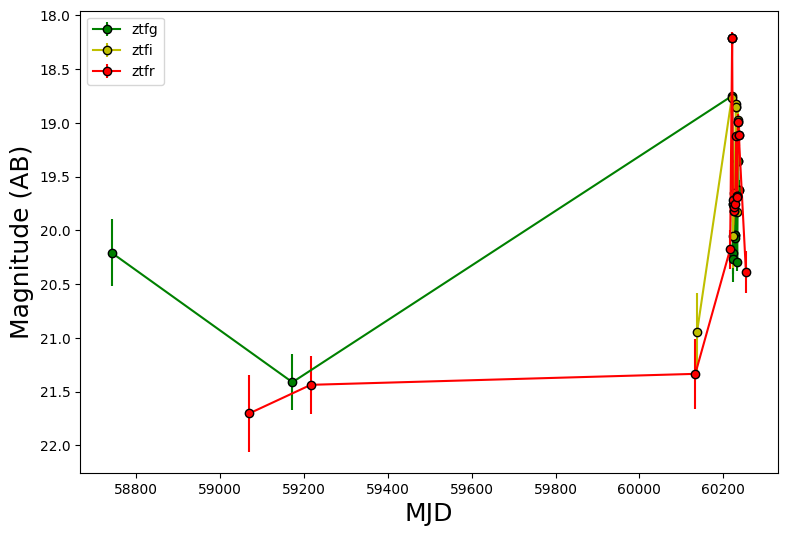

In [26]:
import matplotlib.pyplot as plt

color_dict = {'ztfg': 'green', 'ztfr': 'red', 'ztfi': 'y',
              'sdssg': 'green', 'sdssr': 'red', 'sdssi': 'y',
              'atlasc': 'cyan', 'atlaso': 'orange',}

def plot_photometry(lc):

    
    fig, ax1 = plt.subplots(1, 1, figsize=(9,6))
    ymin, ymax = np.inf, -np.inf

    for f in set(lc['filter']):
        tf = lc[lc['filter'] == f]
        
        tf_det = tf[tf['mag'] >= 3.]
        tf_ul = tf[tf['snr'] < 3]

        ax1.errorbar(tf_det['mjd'].values,
                     tf_det['mag'], yerr=tf_det['magerr'],
                     color=color_dict[f], markeredgecolor='k',
                     label=f, marker='o')
        if np.min(tf_det['mag']) < ymin:
            ymin = np.min(tf_det['mag'])
        if np.max(tf_det['mag']) > ymax:
            ymax = np.max(tf_det['mag'])

        if len(tf_ul) != 0:
            ax1.errorbar(tf_ul['mjd'].values, tf_ul['limiting_mag'],
                         markeredgecolor=color_dict[f],
                         markerfacecolor='w', fmt='v')
            plt.plot([],[], 'kv', markeredgecolor='k', markerfacecolor='w',
                     label='upper limits')

            if np.min(tf_det['limiting_mag']) < ymin:
                ymin = np.min(tf_det['limiting_mag'])
            if np.max(tf_det['limiting_mag']) > ymax:
                ymax = np.max(tf_det['limiting_mag'])
    
    plt.gca().invert_yaxis()

    ax1.set_xlabel(f"MJD", fontsize=18)
    ax1.set_ylabel("Magnitude (AB)", fontsize=18)
    plt.legend()

lc = pd.DataFrame.from_dict(photometry)
plot_photometry(lc)

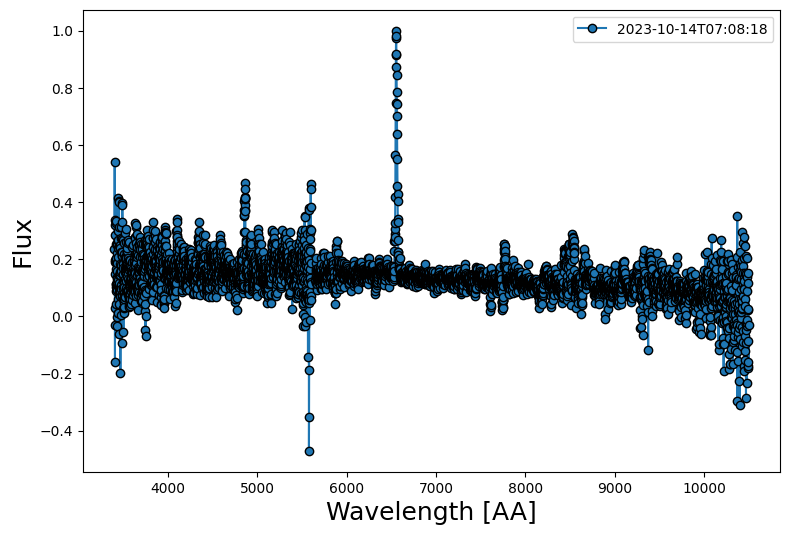

In [27]:
import matplotlib.pyplot as plt

def plot_spectra(spec):

    
    fig, ax1 = plt.subplots(1, 1, figsize=(9,6))
    ymin, ymax = np.inf, -np.inf

    for index, row in spec.iterrows():
        
        wavelength = row['wavelengths']
        flux = np.array(row['fluxes'], dtype=np.float64)
        fluxerr = np.array(row['errors'], dtype=np.float64)
        observed_at = row['observed_at']
        
        norm = np.nanmax(flux)
        flux = flux / norm
        fluxerr = fluxerr / norm

        ax1.errorbar(wavelength,
                     flux,
                     markeredgecolor='k',
                     label=observed_at, marker='o')
        if np.nanmin(flux) < ymin:
            ymin = np.nanmin(flux)
        if np.nanmax(flux) > ymax:
            ymax = np.nanmax(flux)

    ax1.set_xlabel(f"Wavelength [AA]", fontsize=18)
    ax1.set_ylabel("Flux", fontsize=18)
    plt.legend()

spec = pd.DataFrame.from_dict(spectra['spectra'])
plot_spectra(spec)

In [2]:
import json

def convert_json_to_dat(input_json_path, output_dat_path):
    with open(input_json_path, "r") as infile:
        data = json.load(infile)

    lines = []
    for entry in data:
        time = entry["time (isot)"]
        filt = entry["filter"]
        mag = entry["mag"]
        mag_err = entry["mag_error"]

        # Handle infinite mag_error from JSON ("Infinity" or float("inf"))
        if mag_err == float("inf") or mag_err == "Infinity":
            mag_err_str = "inf"
        else:
            mag_err_str = str(mag_err)

        line = f"{time} {filt} {mag} {mag_err_str}"
        lines.append(line)

    with open(output_dat_path, "w") as outfile:
        for line in lines:
            outfile.write(line + "\n")

convert_json_to_dat('./data/GRB211211A/GRB211211A.json','./data/GRB211211A/GRB211211A.dat')

In [4]:
read_lightcurve_file('./data/GRB211211A/GRB211211A.dat')

,2021-12-11T14:21:59.000,uvot::v,19.17,0.29
0,2021-12-11T14:21:59.000,uvot::v,19.17,0.29
1,2021-12-12T06:41:11.000,uvot::v,19.21,inf
2,2021-12-12T11:14:47.000,uvot::v,19.20,inf
3,2021-12-11T14:07:35.000,uvot::b,19.65,0.23
4,2021-12-11T17:57:59.000,uvot::b,19.82,0.19
...,...,...,...,...
106,2021-12-12T08:05:00.026,X-ray-1keV,25.91,0.26
107,2021-12-12T10:03:29.591,X-ray-1keV,26.88,0.20
108,2021-12-12T22:05:12.955,X-ray-1keV,28.74,0.20
109,2022-05-01T01:56:35.091,X-ray-1keV,28.75,inf
